<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/Concept%20drift%EC%9D%98%20%ED%83%90%EC%A7%80%20%EB%B0%A9%EB%B2%95_0114.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concept drift의 탐지 방법 <br>

concept drift detect method

# 1. Introduction

* Data Drift의 상황에서는 재학습 (retrain)을 하면 되지만, Concept Drift 상황에서는 p(y|x)의 상관관계가 변화되었으므로 새롭게 모델을 학습 즉, remodeling을 해야 한다.
* 하지만, on-line data에 대하여 Drift를 측정(ks-test 등)할 수 있어도, 이 상황이 Data Drift (or virtual concept drift)인지 진짜 Concept Drift인지를 파악하기 어렵다.
* 이런 상황에서 단순히 재학습을 하여 모델을 운영한다면, 역시 성능 회복이 안될 것이며, 이를 인지하지 못한 상태로 모델을 계속 운영할 수 있다.
* 이러한 운영상의 문제점을 극복하기 위해, Concept Drift를 탐지하고자 한다. 












# 2. 이론적 배경



# 3. Proposed Method

## pseudo code

# 4. 실험 계획

*   Data
1. Personal Loan Data
> 미국의 개인 대출 기업 ‘Lending Club’의 공개 데이터 사용<BR>
> 2007~2017년까지 총 2,260,701건의 데이터, 대출 건당 실제 ‘default’ 여부 포함
151개 Column<BR>
> 데이터 정제 후, 81개 Features, 120만건 사용<BR>
>> trainset : 11,497건 (2010년)<BR>
>> online dataset : 1,268,183건 (2011~2017년)<BR>



# 5. 실험을 위한 기본 준비 

In [1]:
if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install shap
!pip3 install alibi-detect
!pip3 install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 11.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.9/306.9 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 98.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 111.7 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.39.1
    Uninstalling llvmlite-0.39.1:
      Successfully uninstalled llvmlite-0.39.1
  Attempting uninstall: numba
    Found existing installation: numba 0.56.4
 

In [3]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import random
np.random.seed(1337)

In [4]:
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    

# 7. loan predict 실험

## 데이터 구축

In [5]:
df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(2260701, 151)


### 데이터 정제

In [6]:
# for the sake of simplicity, let's consider only Fully Paid and Charged Off values:

df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]

print(df_accepted.shape)

(1345310, 151)


In [7]:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1345310, 101)

In [8]:
# maybe we can go further, and eliminate columns up to title:

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1345310, 56)

In [9]:
# Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():

df_accepted = df_accepted.dropna()
df_accepted.shape

(1341026, 56)

In [10]:
# These are constant columns. We can drop it either.

cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1341026, 53)

In [11]:
# It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:

cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1341026, 44)

In [12]:
values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))

df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)

df_accepted = df_accepted.drop(columns=['loan_status'])


In [13]:
df_accepted

,id,loan_amnt,term,int_rate,grade,sub_grade,home_ownership,annual_inc,verification_status,issue_d,...,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,disbursement_method,debt_settlement_flag,loan_paid
0,68407277,3600.0,36 months,13.99,C,C4,MORTGAGE,55000.0,Not Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
1,68355089,24700.0,36 months,11.99,C,C1,MORTGAGE,65000.0,Not Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2,68341763,20000.0,60 months,10.78,B,B4,MORTGAGE,63000.0,Not Verified,Dec-2015,...,Joint App,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
4,68476807,10400.0,60 months,22.45,F,F1,MORTGAGE,104433.0,Source Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
5,68426831,11950.0,36 months,13.44,C,C3,RENT,34000.0,Source Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,89905081,18000.0,60 months,9.49,B,B2,OWN,130000.0,Not Verified,Oct-2016,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2260690,88948836,29400.0,60 months,13.99,C,C3,MORTGAGE,180792.0,Not Verified,Oct-2016,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2260691,89996426,32000.0,60 months,14.49,C,C4,MORTGAGE,157000.0,Source Verified,Oct-2016,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,0
2260692,90006534,16000.0,60 months,12.79,C,C1,RENT,150000.0,Not Verified,Oct-2016,...,Individual,0.0,0.0,0.0,3.0,0.0,N,Cash,N,1


In [14]:
# droping constant columns

print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())

cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

n    1341026
Name: pymnt_plan, dtype: int64
N    1341026
Name: hardship_flag, dtype: int64


(1341026, 41)

In [15]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')
 36 months    1017398
 60 months     323628
Name: term, dtype: int64
Index(['home_ownership', 'verification_status', 'issue_d', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')


In [16]:
df_accepted.shape

(1341026, 86)

In [17]:
df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])
df_accepted.shape

(1341026, 83)

In [18]:
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

In [19]:
def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

'200901'

In [20]:
 df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
 df_accepted = df_accepted.sort_values(by='issue_d')
 df_accepted.reset_index(drop=True, inplace=True)

In [21]:
df_accepted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341026 entries, 0 to 1341025
Data columns (total 83 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   loan_amnt                   1341026 non-null  float64
 1   term                        1341026 non-null  int64  
 2   int_rate                    1341026 non-null  float64
 3   annual_inc                  1341026 non-null  float64
 4   issue_d                     1341026 non-null  object 
 5   dti                         1341026 non-null  float64
 6   delinq_2yrs                 1341026 non-null  float64
 7   fico_range_high             1341026 non-null  float64
 8   inq_last_6mths              1341026 non-null  float64
 9   open_acc                    1341026 non-null  float64
 10  pub_rec                     1341026 non-null  float64
 11  revol_bal                   1341026 non-null  float64
 12  revol_util                  1341026 non-null  float64
 1

In [22]:
df_accepted[['G1','G2','G3','G4']]

,G1,G2,G3,G4
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
1341021,0,0,0,0
1341022,0,0,0,0
1341023,0,0,0,0
1341024,0,0,0,0


### dataset 만들기

In [23]:
X = {}
Y = {}

In [24]:
# sampling data

# df = df_accepted.sample(frac=0.8,random_state=42)
# print(len(df))

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])


/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:214: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [25]:
df.shape

(5797, 82)

In [26]:
X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values

In [27]:
for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

2010
2011
2012
2013
2014
2015
2016
2017
2018


In [28]:
X[2010].shape

(11497, 81)

In [29]:
COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns

In [30]:
COLUMNS

Index(['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'last_pymnt_amnt', 'last_fico_range_high',
       'collections_12_mths_ex_med', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies',
       'tax_liens', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3',
       'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5',
       'Source Verified', 'Verified', 'Joint App', 'w', 'credit_card',
       'debt_consolidation', 'educational', 'home_improvement', 'house',
       'major_purchase', 'medical', 'moving', 'other', 'renewable_energy',
       'small_business', 'vacation', 'wedding', 'MORTGAGE', 'OTHER', 'OWN',
       'RENT', 'DirectPay', 'Y'],
      dtype

## 예측 모델 구축

In [31]:
ML = {}
scaler = MinMaxScaler()

In [32]:
MODEL_TYPE = 'RF'  ## RF / DL

### random forest 모델

In [33]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

In [34]:
from sklearn.ensemble import RandomForestClassifier

def build_model_rf(year,x,y,epochs=5):
    X_train= scaler.fit_transform(x)
    y_train = y #get_one_hot(y,2)
    model = RandomForestClassifier(n_estimators=80,max_depth=5)
    model.fit(X_train,y_train)
    return model

### loan predict model build

In [35]:
seed_everything()

offset = int(Y[2010].shape[0] * 0.7)
y_ref = Y[2010][0:offset]
x_ref = X[2010][0:offset]
y_inf = Y[2010][offset:]
x_inf = X[2010][offset:]

ML[2010] = build_model_rf(year,x_ref,y_ref,epochs=5)

In [36]:
dd = np.zeros((4,4))
# add intercept term
intc = np.ones((dd.shape[0],1))
dd = np.concatenate((dd,intc),axis=1)
dd.shape

(4, 5)

In [37]:
from sklearn.metrics import precision_recall_fscore_support

base_score = precision_recall_fscore_support(y_inf, ML[2010].predict(scaler.transform(x_inf)),average='binary')
base_score

(0.9908045977011494, 1.0, 0.9953810623556583, None)

## loan predict model의 성능 예측 실험

In [38]:
# 2010년의 data를 기준으로 그 이후의 data 들...
X2 = np.concatenate((X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))

In [39]:
print("trainset:",X[2010].shape)
print("online dataset:",X2.shape)

trainset: (11497, 81)
online dataset: (1268183, 81)


### 실험

#### RF의 feature importance 

In [40]:
importances = ML[2010].feature_importances_
imp_df1 = pd.DataFrame(importances.reshape(1,-1),columns=COLUMNS)

forest_importances = pd.Series(importances, index=COLUMNS)
monitoring_feature = list(forest_importances.sort_values(ascending=False).keys()[0:10])
print(monitoring_feature)

#imp_df1.loc[len(imp_df1)] = importances

#forest_importances.to_dict()
#importances.reshape(-1,1)

imp_df1[monitoring_feature]

['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'int_rate', 'term', 'Y', 'fico_range_high', 'total_rec_int', 'revol_util']


,recoveries,last_fico_range_high,last_pymnt_amnt,total_rec_late_fee,int_rate,term,Y,fico_range_high,total_rec_int,revol_util
0,0.558539,0.172298,0.094741,0.029876,0.023612,0.022712,0.018601,0.010657,0.008728,0.008422


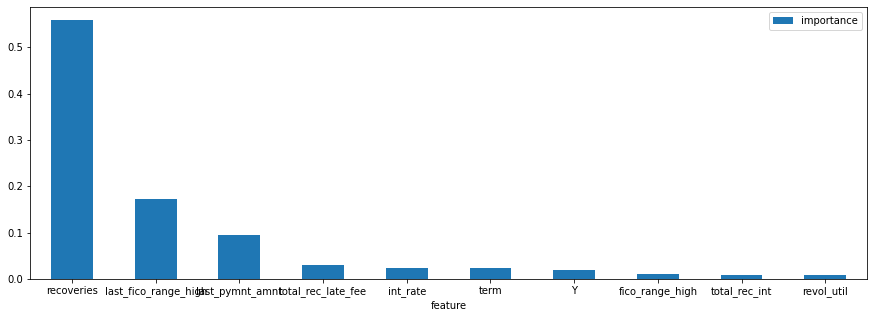

In [44]:
df = pd.DataFrame({'feature':monitoring_feature, 'importance':imp_df1[monitoring_feature].values[0]})
df.plot.bar(x='feature',rot=0,figsize=(15,5))


#### shap에 의한 feature importance 분석

In [45]:
import shap
import sys
from alibi_detect.cd import ChiSquareDrift, KSDrift, ClassifierDrift

In [98]:
explainer = shap.TreeExplainer(ML[2010])
shap_values = explainer.shap_values(scaler.fit_transform(x_ref))
vals= np.abs(shap_values).mean(0)
feature_importance = {}
for (fname,imp_val) in zip(COLUMNS,np.mean(vals,axis=0)):
    feature_importance[fname] = [imp_val] # (imp_val,0,0,0)  # (importance_value, drift, p_val, is_drift)

imp_df2 = pd.DataFrame(feature_importance)

sorted_feature = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1][0],reverse=True)}
top = 10
monitoring_feature = np.array(list(sorted_feature.keys()))[0:top]
imp_df2[monitoring_feature]

,recoveries,last_fico_range_high,last_pymnt_amnt,term,int_rate,total_rec_late_fee,fico_range_high,revol_util,total_rec_int,inq_last_6mths
0,0.094812,0.032824,0.024673,0.008705,0.006095,0.004352,0.00343,0.001882,0.001772,0.001544


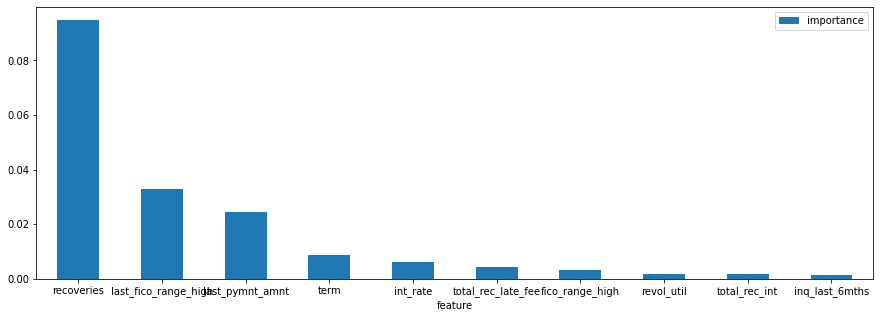

In [90]:
df = pd.DataFrame({'feature':monitoring_feature, 'importance':imp_df2[monitoring_feature].values[0]})
df.plot.bar(x='feature',rot=0,figsize=(15,5))


#### Mutual information에 의한 feature importance 분석

In [49]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


In [50]:
discrete_features = pd.DataFrame(X[2010],columns=COLUMNS).dtypes == int

                feature  importance
0            recoveries    0.365558
1       last_pymnt_amnt    0.082770
2  last_fico_range_high    0.077879
3    total_rec_late_fee    0.037701
4  pub_rec_bankruptcies    0.023600
5                    D5    0.019203
6                  term    0.016597
7               pub_rec    0.015865
8                    B2    0.015777
9              int_rate    0.015685


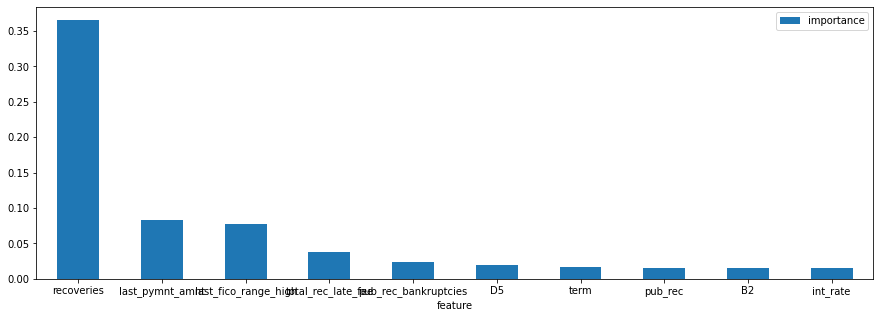

In [51]:
mi_scores = make_mi_scores(pd.DataFrame(scaler.fit_transform(x_ref),columns=COLUMNS), y_ref, discrete_features=discrete_features)
imp_df_mi = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))

imp_df3 = pd.DataFrame({'feature':mi_scores.keys()[:10],'importance':mi_scores.values[:10]})
print(imp_df3)
imp_df3.plot.bar(x='feature',rot=0,figsize=(15,5))

## Random-forest, 성능 추이

각 step 마다의 random-forest, shap, MI의 importance를 측정한다.
ground-truth의 Y를 사용한다.

In [96]:
import math

batch_size = 10000
batch = math.ceil(X2.shape[0]/batch_size)
df = {}
df['f1'] = []
#df['f1_c'] = []
REFERENCE_YEAR = 2010
scaler = MinMaxScaler()
scaler.fit(x_ref)

#Random-forest
predict = ML[REFERENCE_YEAR].predict
importances = ML[REFERENCE_YEAR].feature_importances_
#imp_df = pd.DataFrame(importances.reshape(1,-1),columns=COLUMNS)

imp_df_rf = pd.DataFrame(importances.reshape(1,-1),columns=COLUMNS)

# SHAP
explainer = shap.TreeExplainer(ML[2010])
shap_values = explainer.shap_values(scaler.transform(x_ref))
vals= np.abs(shap_values).mean(0)
feature_importance = {}
for (fname,imp_val) in zip(COLUMNS,np.mean(vals,axis=0)):
    feature_importance[fname] = [imp_val] # (imp_val,0,0,0)  # (importance_value, drift, p_val, is_drift)
imp_df_sh = pd.DataFrame(feature_importance)

#MI
mi_scores = make_mi_scores(pd.DataFrame(scaler.transform(x_ref),columns=COLUMNS), y_ref, discrete_features=discrete_features)
imp_df_mi = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]


for i in range(batch):
    X3 = X2[i*batch_size:(i+1)*batch_size]
    Y3 = Y2[i*batch_size:(i+1)*batch_size]
    Y3_ = predict(scaler.transform(X3))
    f1 = precision_recall_fscore_support(Y3, Y3_ ,average='binary')
    #X3_drift = ks_drift(x_ref,X3)[:,0]
    #acc_c = model_c.predict(X3_drift.reshape(1,-1))[0]

    #print(f"{f1[2]}, {acc_c[2]}")
    df['f1'].append(f1[2])
    #df['f1_c'].append(acc_c[2])

    #################  importance 측정

    scaler = MinMaxScaler()
    scaler.fit(X3)

    # RF
    model2 = RandomForestClassifier(n_estimators=80,max_depth=5)
    model2.fit(scaler.transform(X3),Y3)
    imp_df_rf.loc[len(imp_df_rf)] = model2.feature_importances_
    # SHAP
    explainer = shap.TreeExplainer(model2)
    shap_values = explainer.shap_values(scaler.transform(X3))
    vals= np.abs(shap_values).mean(0)
    imp_df_sh.loc[len(imp_df_sh)] = np.mean(vals,axis=0).reshape(-1,)
    #MI
    mi_scores = make_mi_scores(pd.DataFrame(scaler.transform(X3),columns=COLUMNS), Y3, discrete_features=discrete_features)
    tmp_df = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
    imp_df_mi.loc[len(imp_df_mi)] = tmp_df.values.reshape(-1,)

    print(f"\r{i+1}/{batch} f1:{f1[2]:.4f}", end="", flush=True)


df1 = pd.DataFrame(df)



127/127 f1:0.9316

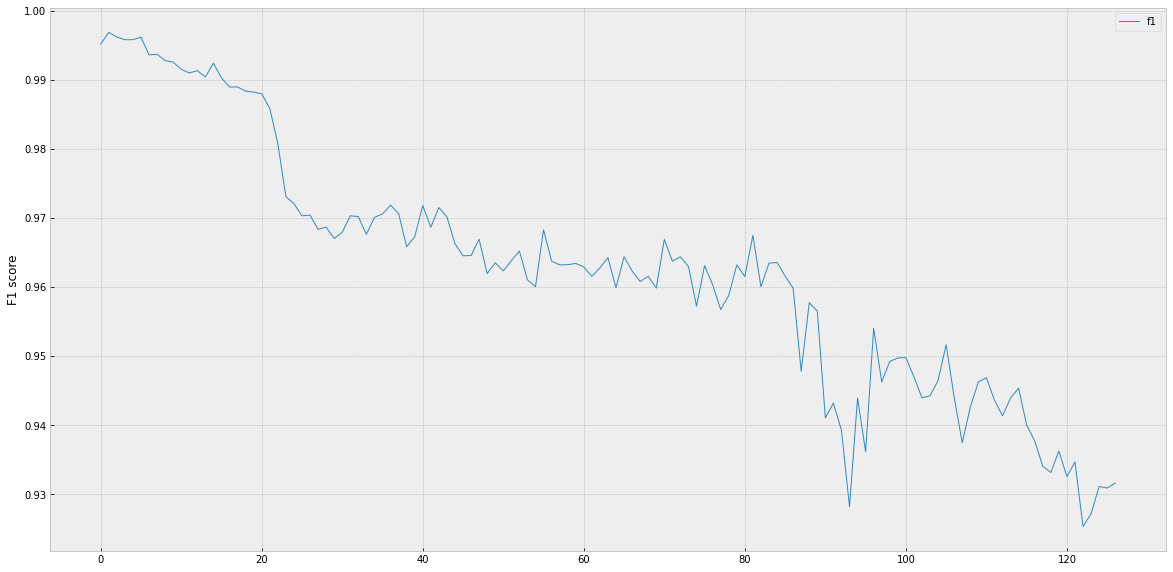

In [97]:
plt.style.use('bmh')
df1.plot(ylabel='F1 score',linewidth=1,figsize=(20,10))

In [99]:
monitoring_feature

array(['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'term',
       'int_rate', 'total_rec_late_fee', 'fico_range_high', 'revol_util',
       'total_rec_int', 'inq_last_6mths'], dtype='<U26')

[]

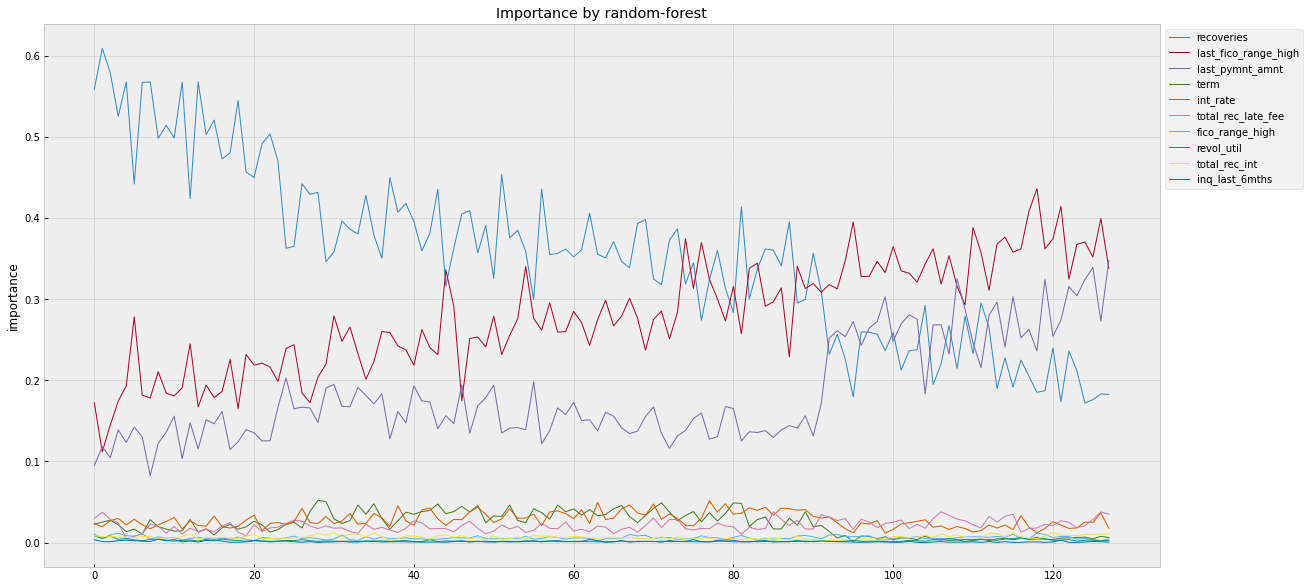

In [104]:
ax = imp_df_rf[monitoring_feature].plot(ylabel='importance',linewidth=1,figsize=(20,10),legend=True)
ax.set_title("Importance by random-forest",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

[]

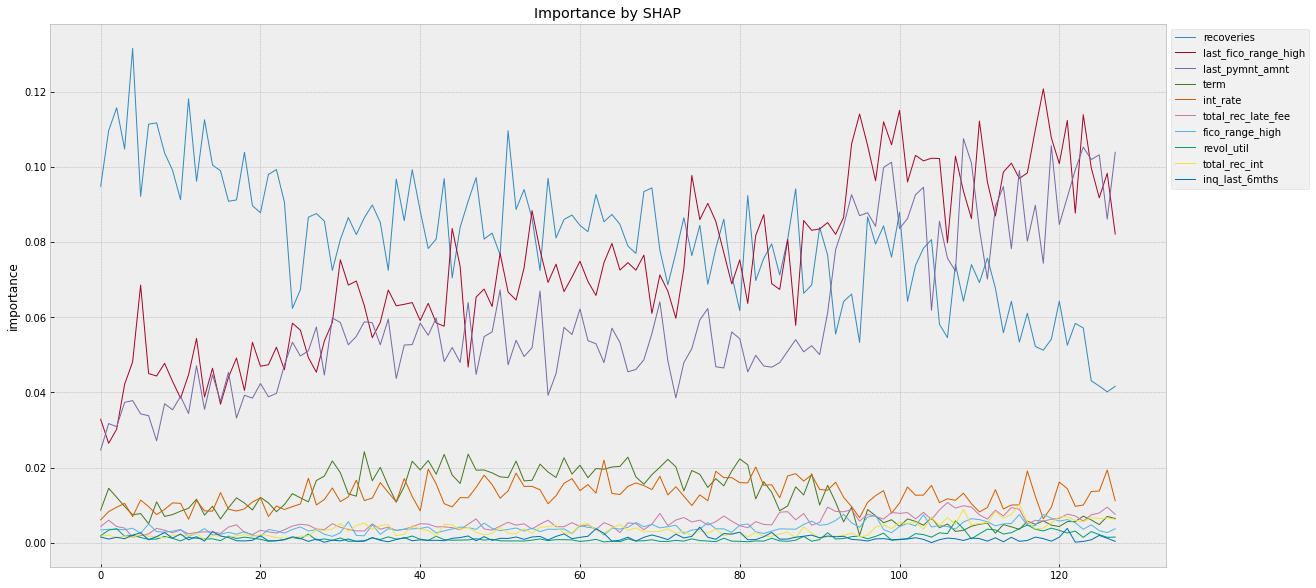

In [105]:
ax = imp_df_sh[monitoring_feature].plot(ylabel='importance',linewidth=1,figsize=(20,10),legend=True)
ax.set_title("Importance by SHAP",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

[]

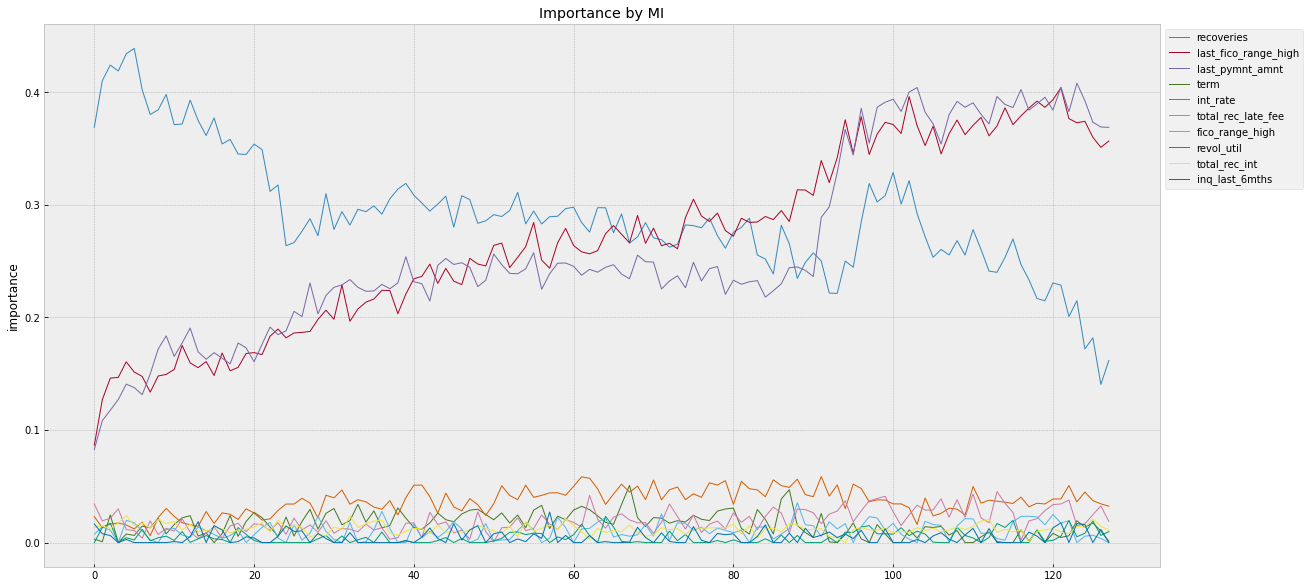

In [106]:
ax = imp_df_mi[monitoring_feature].plot(ylabel='importance',linewidth=1,figsize=(20,10),legend=True)
ax.set_title("Importance by MI",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

## 예측 Y에 의한 importance 측정

In [108]:
batch_size = 10000
batch = math.ceil(X2.shape[0]/batch_size)
df = {}
df['f1'] = []
#df['f1_c'] = []
REFERENCE_YEAR = 2010
scaler = MinMaxScaler()
scaler.fit(x_ref)

#Random-forest
predict = ML[REFERENCE_YEAR].predict
importances = ML[REFERENCE_YEAR].feature_importances_
#imp_df = pd.DataFrame(importances.reshape(1,-1),columns=COLUMNS)

imp_df_rf = pd.DataFrame(importances.reshape(1,-1),columns=COLUMNS)

# SHAP
explainer = shap.TreeExplainer(ML[2010])
shap_values = explainer.shap_values(scaler.transform(x_ref))
vals= np.abs(shap_values).mean(0)
feature_importance = {}
for (fname,imp_val) in zip(COLUMNS,np.mean(vals,axis=0)):
    feature_importance[fname] = [imp_val] # (imp_val,0,0,0)  # (importance_value, drift, p_val, is_drift)
imp_df_sh = pd.DataFrame(feature_importance)

#MI
mi_scores = make_mi_scores(pd.DataFrame(scaler.transform(x_ref),columns=COLUMNS), y_ref, discrete_features=discrete_features)
imp_df_mi = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]


for i in range(batch):
    X3 = X2[i*batch_size:(i+1)*batch_size]
    Y3 = Y2[i*batch_size:(i+1)*batch_size]
    Y3_ = predict(scaler.transform(X3))
    f1 = precision_recall_fscore_support(Y3, Y3_ ,average='binary')
    #X3_drift = ks_drift(x_ref,X3)[:,0]
    #acc_c = model_c.predict(X3_drift.reshape(1,-1))[0]

    #print(f"{f1[2]}, {acc_c[2]}")
    df['f1'].append(f1[2])
    #df['f1_c'].append(acc_c[2])

    #################  importance 측정

    scaler = MinMaxScaler()
    scaler.fit(X3)

    # RF
    model2 = RandomForestClassifier(n_estimators=80,max_depth=5)
    model2.fit(scaler.transform(X3),Y3_)
    imp_df_rf.loc[len(imp_df_rf)] = model2.feature_importances_
    # SHAP
    explainer = shap.TreeExplainer(model2)
    shap_values = explainer.shap_values(scaler.transform(X3))
    vals= np.abs(shap_values).mean(0)
    imp_df_sh.loc[len(imp_df_sh)] = np.mean(vals,axis=0).reshape(-1,)
    #MI
    mi_scores = make_mi_scores(pd.DataFrame(scaler.transform(X3),columns=COLUMNS), Y3_, discrete_features=discrete_features)
    tmp_df = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
    imp_df_mi.loc[len(imp_df_mi)] = tmp_df.values.reshape(-1,)

    print(f"\r{i+1}/{batch} f1:{f1[2]:.4f}", end="", flush=True)


df1 = pd.DataFrame(df)

127/127 f1:0.9316

[]

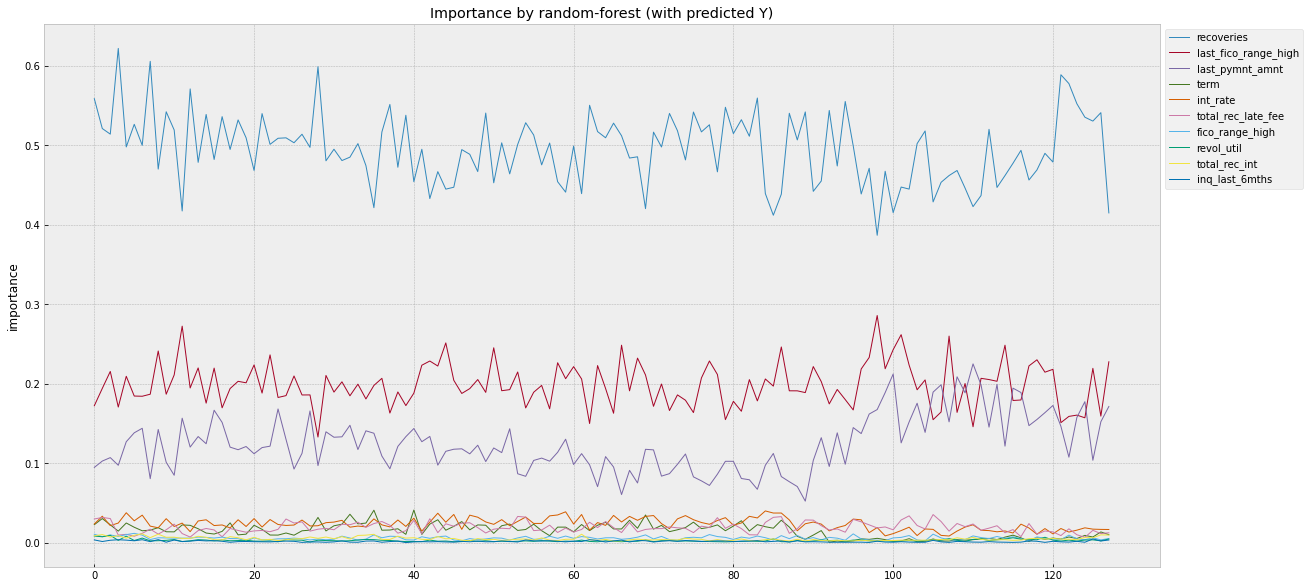

In [110]:
ax = imp_df_rf[monitoring_feature].plot(ylabel='importance',linewidth=1,figsize=(20,10),legend=True)
ax.set_title("Importance by random-forest (with predicted Y)",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

[]

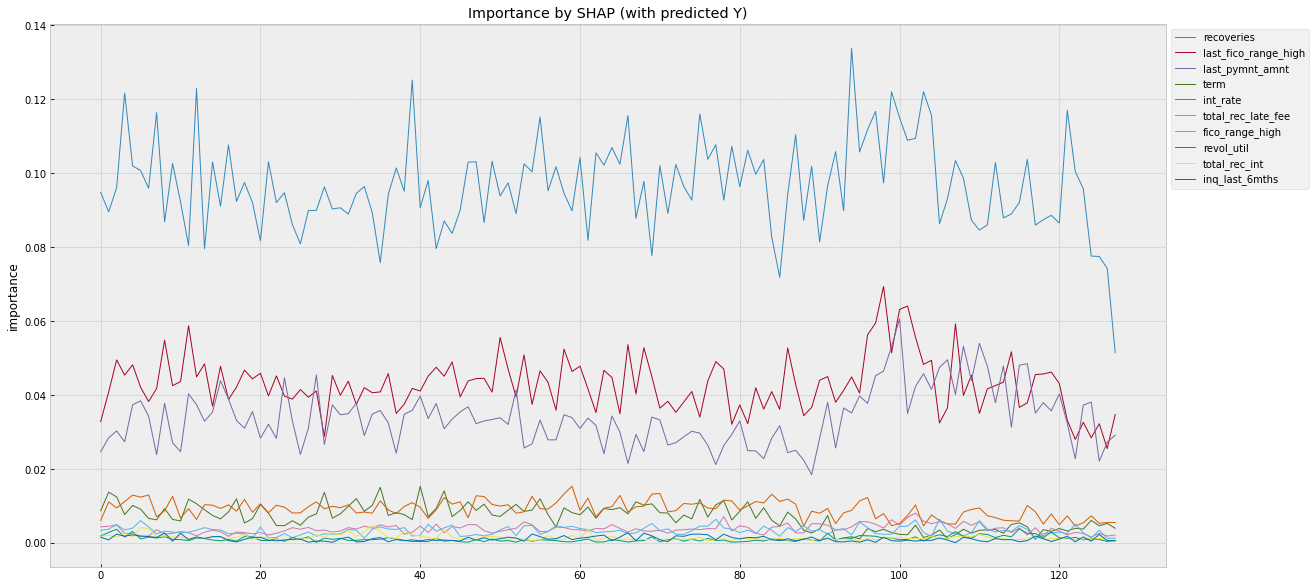

In [111]:
ax = imp_df_sh[monitoring_feature].plot(ylabel='importance',linewidth=1,figsize=(20,10),legend=True)
ax.set_title("Importance by SHAP (with predicted Y)",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

[]

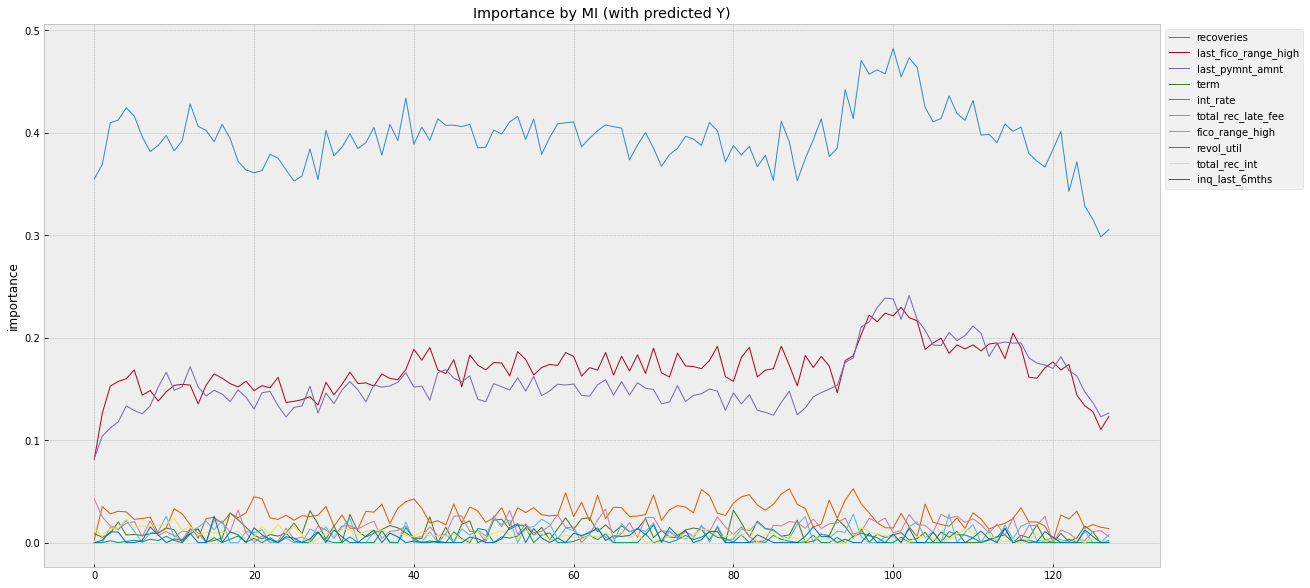

In [112]:
ax = imp_df_mi[monitoring_feature].plot(ylabel='importance',linewidth=1,figsize=(20,10),legend=True)
ax.set_title("Importance by MI (with predicted Y)",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

## Deep learning 모델의 실험

In [40]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])
     

In [73]:
import os.path 

def build_model_dl(year,x,y,epochs=5,verbose=1):
    #X_train, X_test, y_train, y_test = train_test_split(X[year], Y[year], test_size=0.2, random_state=42)
    X_train= scaler.transform(x)
    #X_test = scaler.transform(X_test)
    y_train = get_one_hot(y,2)

    # building the model
    model = Sequential()
    model.add(Dense(units=81*2,activation='relu'))
    model.add(Dense(units=39,activation='relu'))
    model.add(Dense(units=2,activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    weight_path = '/content/drive/MyDrive/Drift/model/ml_'+str(year)
    """
    if os.path.exists(weight_path+'.index'):
        model.load_weights(weight_path)
        print('load weights from ',weight_path)
    else:
        model.fit(x=X_train, 
                y=y_train, 
                epochs=epochs,
                batch_size=512,
                verbose=1)
            #validation_data=(X_test, y_test), verbose=1)
        if year > 2000:
            model.save_weights(weight_path) 
            print('save weights to ',weight_path)
    """
    model.fit(x=X_train, 
            y=y_train, 
            epochs=epochs,
            batch_size=512,
            verbose=verbose)
        #validation_data=(X_test, y_test), verbose=1)


    return model

In [153]:
get_one_hot(y_ref[0:10],2)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [74]:
scaler = MinMaxScaler()
scaler.fit(x_ref)

deep_model = build_model_dl(2010,x_ref,y_ref,epochs=100)

Epoch 1/100
16/16 [==============================] - 1s 3ms/step - loss: 0.5947 - accuracy: 0.7196
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4028 - accuracy: 0.8721
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3817 - accuracy: 0.8721
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3650 - accuracy: 0.8721
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3551 - accuracy: 0.8721
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3456 - accuracy: 0.8721
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3375 - accuracy: 0.8721
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3294 - accuracy: 0.8721
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3206 - accuracy: 0.8721
Epoch 10/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3108 - accuracy: 0.8731
Epoch 11/

#### deep 모델에 대한 Test

In [61]:
x_inf.shape

(3450, 81)

In [75]:
import shap
import sys

scaler = MinMaxScaler()
scaler.fit(x_ref)

background = x_ref[np.random.choice(x_ref.shape[0], 1000, replace=False)]
sample_inf = x_inf[np.random.choice(x_inf.shape[0], 1000, replace=False)]

explainer = shap.DeepExplainer(deep_model,scaler.transform(background))
shap_values = explainer.shap_values(scaler.transform(sample_inf))
vals= np.abs(shap_values).mean(0)
feature_importance = {}
for (fname,imp_val) in zip(COLUMNS,np.mean(vals,axis=0)):
    feature_importance[fname] = [imp_val] # (imp_val,0,0,0)  # (importance_value, drift, p_val, is_drift)

imp_df2 = pd.DataFrame(feature_importance)

sorted_feature = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1][0],reverse=True)}
top = 10
monitoring_feature = np.array(list(sorted_feature.keys()))[0:top]
imp_df2[monitoring_feature]

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
array([[1.        , 0.        , 0.47410604, ..., 0.        , 0.        ,
        0.        ],
       [0.375     , 1.        , 0.39704069, ..., 0.        , 0.        ,
        0.        ],
       [0.5       , 0.        , 0.48150432, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.35833333, 0.        , 0.39704069, ..., 0.        , 0.        ,
        0.        ],
       [0.375     , 0.        , 0.351418  , ..., 0.        , 0.        ,
        0.        ],
       [0.16666667, 0.        , 0.52774353, ..., 1.        , 0.        ,
        0.        ]])>]. Consider rewriting this model with the Functional API.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your 

,last_pymnt_amnt,recoveries,total_rec_int,loan_amnt,MORTGAGE,RENT,last_fico_range_high,term,int_rate,OWN
0,0.060057,0.053334,0.052466,0.046979,0.043217,0.041421,0.038061,0.021905,0.019355,0.016024


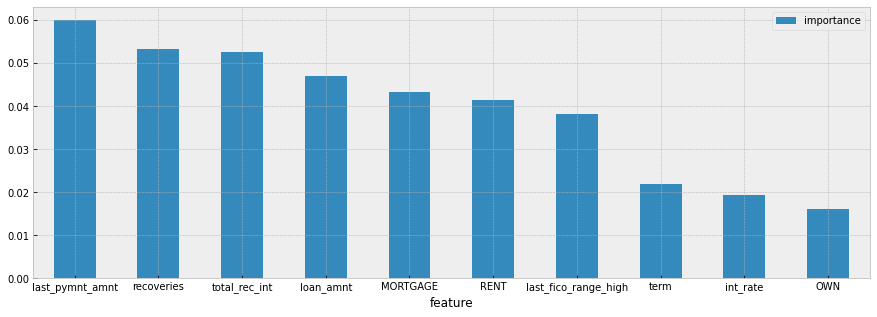

In [76]:
df = pd.DataFrame({'feature':monitoring_feature, 'importance':imp_df2[monitoring_feature].values[0]})
df.plot.bar(x='feature',rot=0,figsize=(15,5))

In [77]:
import math

batch_size = 10000
batch = math.ceil(X2.shape[0]/batch_size)
df = {}
df['f1'] = []
#df['f1_c'] = []
REFERENCE_YEAR = 2010
scaler = MinMaxScaler()
scaler.fit(x_ref)

#MI
mi_scores = make_mi_scores(pd.DataFrame(scaler.transform(x_ref),columns=COLUMNS), y_ref, discrete_features=discrete_features)
imp_df_mi = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]


for i in range(batch):
    X3 = X2[i*batch_size:(i+1)*batch_size]
    Y3 = Y2[i*batch_size:(i+1)*batch_size]
    X3_ = scaler.transform(X3)
    Y3_ = deep_model.predict(X3_,verbose=0)
    Y4_ = np.asarray([0 if _Y[0] > 0.5 else 1 for _Y in Y3_])
    #print(Y3[0:10])
    #print(Y4_[0:10])
    
    f1 = precision_recall_fscore_support(Y3,Y4_,average='binary')
    #X3_drift = ks_drift(x_ref,X3)[:,0]
    #acc_c = model_c.predict(X3_drift.reshape(1,-1))[0]

    #print(f"{f1[2]}, {acc_c[2]}")
    df['f1'].append(f1[2])
    #df['f1_c'].append(acc_c[2])

    #################  importance 측정

    #scaler = MinMaxScaler()
    #scaler.fit(X3)

    # remodeling
    #model2 = build_model_dl(2010,X3,Y4_,epochs=100,verbose=0)

    #MI
    mi_scores = make_mi_scores(pd.DataFrame(X3_,columns=COLUMNS), Y4_, discrete_features=discrete_features)
    tmp_df = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
    imp_df_mi.loc[len(imp_df_mi)] = tmp_df.values.reshape(-1,)

    print(f"\r{i+1}/{batch} f1:{f1[2]:.4f}", end="", flush=True)


df1 = pd.DataFrame(df)



127/127 f1:0.9589

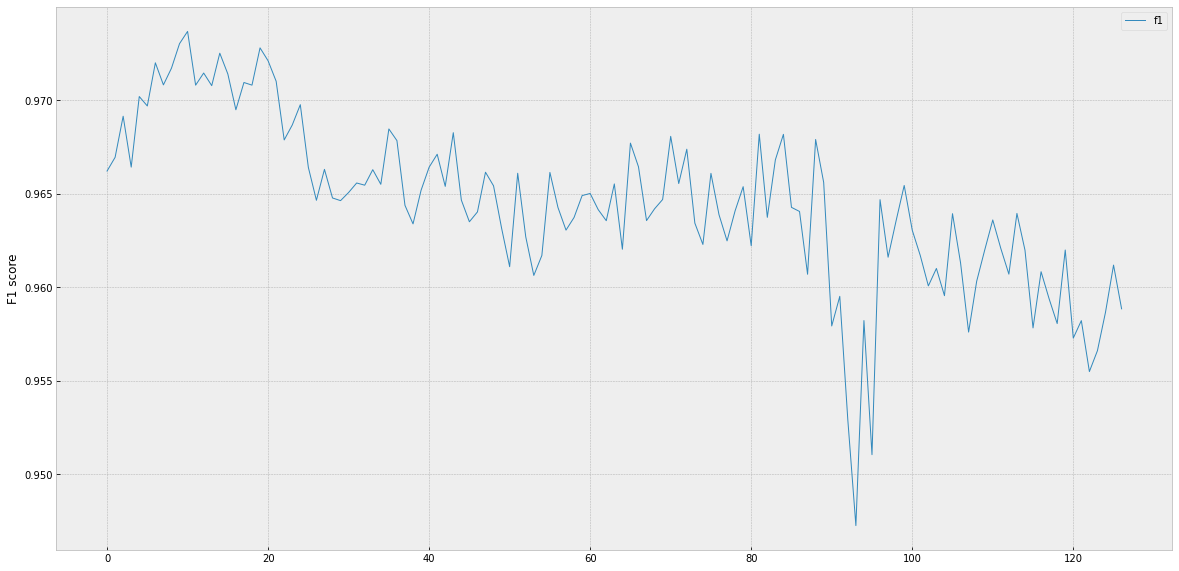

In [78]:
plt.style.use('bmh')
df1.plot(ylabel='F1 score',linewidth=1,figsize=(20,10))

[]

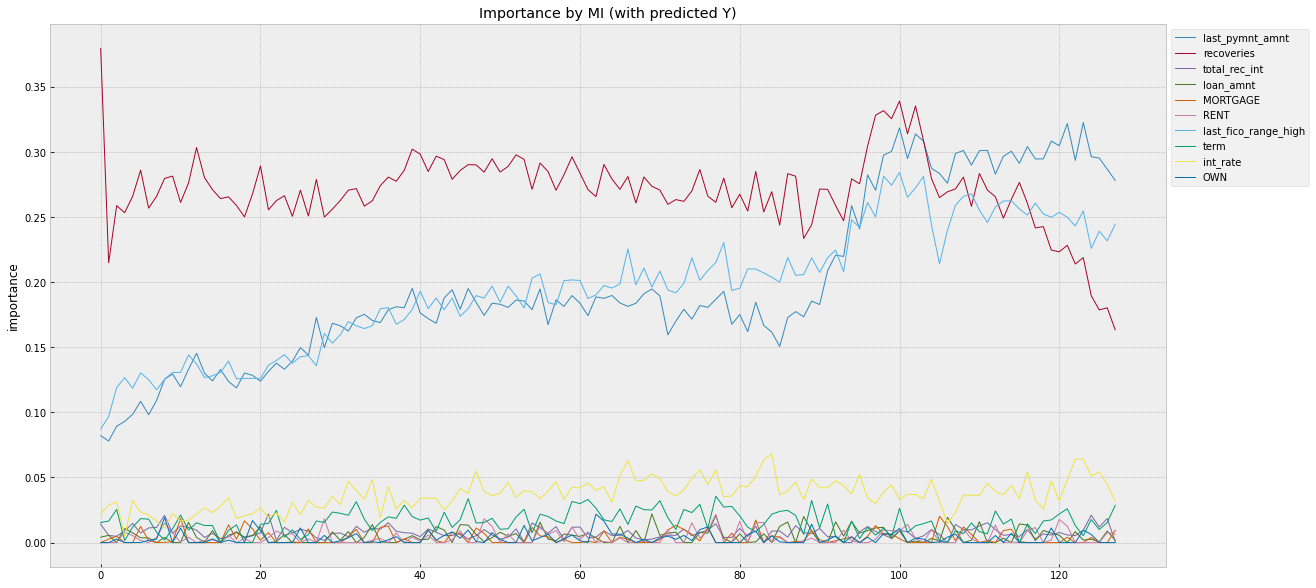

In [80]:
ax = imp_df_mi[monitoring_feature].plot(ylabel='importance',linewidth=1,figsize=(20,10),legend=True)
ax.set_title("Importance by MI (with predicted Y)",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()